In [798]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [684]:
def connect_db():
    db_user = "dev"
    db_passsword = "dev"
    db_host = "localhost"
    db_port = "5432" # map this port in docker-compose
    db_name = "importer-db"
    return create_engine(f"postgresql+psycopg2://{db_user}:{db_passsword}@{db_host}:{db_port}/{db_name}")

# pip install psycopg2
conn = connect_db()

In [685]:
# Helper functions

def query(file_name):
    query = ""
    with open(file_name) as file:
        query = file.read()
    return pd.read_sql_query(query, conn)


def write_to_csv(df, file_name, column_to_clean):
    df = df.copy()
    df[column_to_clean] = df[column_to_clean].str.replace(';', ',')
    df[column_to_clean] = df[column_to_clean].str.replace('\n', ' ')
    df.to_csv(file_name, sep=';')


### Run initial query against database and save to csv

In [687]:
_df = query('./query3.sql') # Edit query3.sql for time range
_df.head()

,id,start_date,notices,has_locations,type,open_uni
0,hy-CUR-128616563,2020-03-10,,True,teaching-participation-lectures,False
1,hy-CUR-128631415,2020-03-09,,True,teaching-participation-lectures,False
2,hy-CUR-128631729,2020-01-17,,True,teaching-participation-lectures,False
3,hy-CUR-128642633,2020-01-13,,True,teaching-participation-seminar,False
4,hy-CUR-128642635,2020-01-13,,True,teaching-participation-seminar,False


In [735]:
df = _df.copy()
print(df.shape)
df.index = df['id']
df['date'] = pd.to_datetime(df['start_date'])
df = df.loc[df['date'] > '2020-01-01']
df['open_uni'] = df['open_uni'].map(bool)
print(df.shape)
write_to_csv(df.drop(['start_date', 'id'], axis=1), './initial_data.csv', column_to_clean='notices')

(20976, 6)
(20976, 7)


### Find keywords in study event notices

Most of them might not be useful but still interesting

In [736]:
df['zoom'] = df['notices'].str.contains('zoom', case=False)
df['etä'] = df['notices'].str.contains(r'\setä', case=False)
df['remote'] = df['notices'].str.contains('remote', case=False)
df['lähi'] = df['notices'].str.contains(r'\slähi', case=False)
df['moodle'] = df['notices'].str.contains('moodle', case=False)
df['has_notices'] = df['notices'].str.strip().str.len() > 3

df.head()

,id,start_date,notices,has_locations,type,open_uni,date,zoom,etä,remote,lähi,moodle,has_notices
id,,,,,,,,,,,,,
hy-CUR-128616563,hy-CUR-128616563,2020-03-10,,True,teaching-participation-lectures,False,2020-03-10,False,False,False,False,False,False
hy-CUR-128631415,hy-CUR-128631415,2020-03-09,,True,teaching-participation-lectures,False,2020-03-09,False,False,False,False,False,False
hy-CUR-128631729,hy-CUR-128631729,2020-01-17,,True,teaching-participation-lectures,False,2020-01-17,False,False,False,False,False,False
hy-CUR-128642633,hy-CUR-128642633,2020-01-13,,True,teaching-participation-seminar,False,2020-01-13,False,False,False,False,False,False
hy-CUR-128642635,hy-CUR-128642635,2020-01-13,,True,teaching-participation-seminar,False,2020-01-13,False,False,False,False,False,False


In [737]:
# convert start_date to date-type and drop unneeded columns
df = df.drop(['id', 'start_date', 'notices'], axis=1)

### Make some derivations

If course type is _teaching-participation-online_ or _exam-electronic_, it clearly is online.

If course does not have registered locations, or has the words 'zoom', 'etä', 'remote' or 'online' in it, it is quite likely online.

Those columns are computed and exported to _data1.csv_ along others.

In [738]:

df['is_online_type'] = df['type'].str.match(r"teaching-participation-online|exam-electronic")

df['likely_online'] = ~df['has_locations'] | df['zoom'] | df['etä'] | df['remote'] | df['is_online_type']

write_to_csv(df, './data1.csv', 'type')
df.head()

,has_locations,type,open_uni,date,zoom,etä,remote,lähi,moodle,has_notices,is_online_type,likely_online
id,,,,,,,,,,,,
hy-CUR-128616563,True,teaching-participation-lectures,False,2020-03-10,False,False,False,False,False,False,False,False
hy-CUR-128631415,True,teaching-participation-lectures,False,2020-03-09,False,False,False,False,False,False,False,False
hy-CUR-128631729,True,teaching-participation-lectures,False,2020-01-17,False,False,False,False,False,False,False,False
hy-CUR-128642633,True,teaching-participation-seminar,False,2020-01-13,False,False,False,False,False,False,False,False
hy-CUR-128642635,True,teaching-participation-seminar,False,2020-01-13,False,False,False,False,False,False,False,False


### Check out the frequency of each column

We can see that keywords occur quite rarely and only 10.7% of courses have notices. 7.66% of courses are specified as online/electronic type. Only about 60% of courses have locations. The end result is that 40% of courses were likely online in some way.

In [739]:
df.drop('type', axis=1).mean() * 100

<ipython-input-739-1b69279e756e>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df.drop('type', axis=1).mean() * 100


has_locations     43.273265
open_uni           6.383486
zoom               1.997521
etä                0.653127
remote             0.634058
lähi               0.133486
moodle             1.063120
has_notices       40.188787
is_online_type    18.020595
likely_online     58.743326
dtype: float64

### Correlation matrix between columns

Just for fun

In [740]:
df.corr()

,has_locations,open_uni,zoom,etä,remote,lähi,moodle,has_notices,is_online_type,likely_online
has_locations,1.000000,-0.067477,0.052050,0.023551,0.011452,0.026047,0.048319,0.373690,-0.392972,-0.959515
open_uni,-0.067477,1.000000,0.003141,-0.021173,-0.018402,-0.009547,-0.021364,-0.101481,0.297176,0.072266
zoom,0.052050,0.003141,1.000000,0.229532,0.010059,0.144096,0.387203,0.174167,-0.052752,0.119645
etä,0.023551,-0.021173,0.229532,1.000000,-0.006477,0.337438,0.424400,0.098915,-0.031856,0.067950
remote,0.011452,-0.018402,0.010059,-0.006477,1.000000,-0.002920,-0.008281,0.097451,-0.037452,0.066944
lähi,0.026047,-0.009547,0.144096,0.337438,-0.002920,1.000000,0.301766,0.044601,-0.017141,0.027987
moodle,0.048319,-0.021364,0.387203,0.424400,-0.008281,0.301766,1.000000,0.126459,-0.043763,0.044381
has_notices,0.373690,-0.101481,0.174167,0.098915,0.097451,0.044601,0.126459,1.000000,-0.304630,-0.333028
is_online_type,-0.392972,0.297176,-0.052752,-0.031856,-0.037452,-0.017141,-0.043763,-0.304630,1.000000,0.392916
likely_online,-0.959515,0.072266,0.119645,0.067950,0.066944,0.027987,0.044381,-0.333028,0.392916,1.000000


### Graph the fraction of online courses every 6 months

At peak around Jan 2021, over 90% of organized courses were likely online. Now in the last 6 months, the same number is under 40%.

Please note that these are charts only rough approximates and are somewhat skewed by the 6 month bucketing.

<AxesSubplot:title={'center':'Fraction of open VS non-open courses likely having online aspects'}, xlabel='date'>

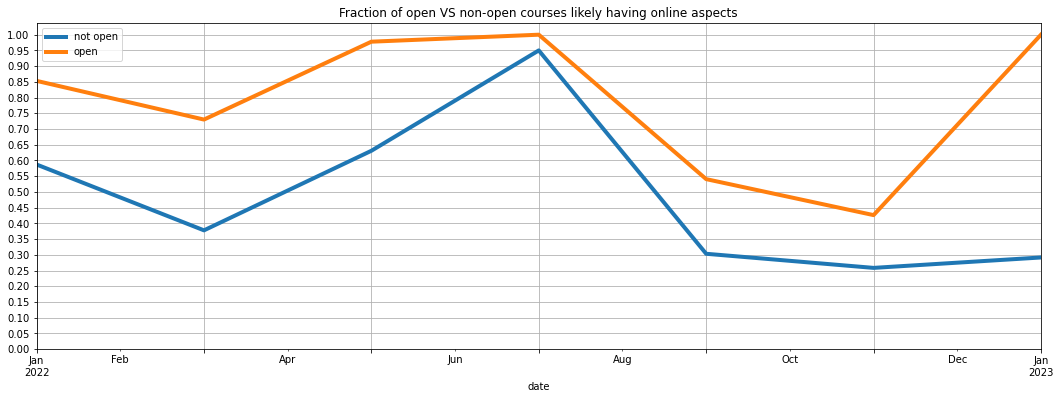

In [768]:
is_teaching = df['type'].str.startswith('teaching')
is_open = df['open_uni']

df0 = df.copy().loc[df['date'] > '2022-01-01']

df1 = df0.loc[is_teaching].loc[~is_open].groupby(pd.Grouper(key="date", freq="2M")).mean()
df2 = df0.loc[is_teaching].loc[is_open].groupby(pd.Grouper(key="date", freq="2M")).mean()
xticks = pd.date_range(start=df1.index[0], end=df1.index[-1], freq='2M')

df1['not open'] = df1['likely_online']
df1['open'] = df2['likely_online']

df1[['not open', 'open']].plot(
    figsize=(18, 6), grid=True, yticks=[x / 20 for x in range(0, 21)], xticks=xticks, linewidth=4,
    title="Fraction of open VS non-open courses likely having online aspects",
    kind="line", legend=True, subplots=False
)



In [764]:
df['all'] = True
period1 = df.copy().loc[(df['date'] >= '2022-08-31') & (df['date'] <= '2022-10-21')].loc[is_teaching]
period2 = df.copy().loc[(df['date'] >= '2022-10-22') & (df['date'] <= '2022-12-21')].loc[is_teaching]
print("I PERIODI (alkavat 31.8-21.10)")
print("Total: " + str(period1['all'].sum()))
print(period1.mean() * 100)
print("\nII PERIODI (alkavat 22.10-21.12)")
print("Total: " + str(period2['all'].sum()))
print(period2.mean() * 100)

I PERIODI (alkavat 31.8-21.10)
Total: 2200
has_locations      74.863636
open_uni            8.727273
zoom                5.772727
etä                 0.727273
remote              0.181818
lähi                0.090909
moodle              0.863636
has_notices        80.681818
is_online_type     14.500000
likely_online      29.363636
all               100.000000
dtype: float64

II PERIODI (alkavat 22.10-21.12)
Total: 1063
has_locations      78.363123
open_uni           12.135466
zoom                5.362183
etä                 0.094073
remote              0.470367
lähi                0.000000
moodle              1.222954
has_notices        82.878645
is_online_type     11.288805
likely_online      25.682032
all               100.000000
dtype: float64


<ipython-input-764-72088d71f238>:6: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  print(period1.mean() * 100)
<ipython-input-764-72088d71f238>:9: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  print(period2.mean() * 100)


### Graph the _absolute number_ of courses every 6 months

<AxesSubplot:title={'center':'Total count of courses VS courses with online aspects'}, xlabel='date', ylabel='Count'>

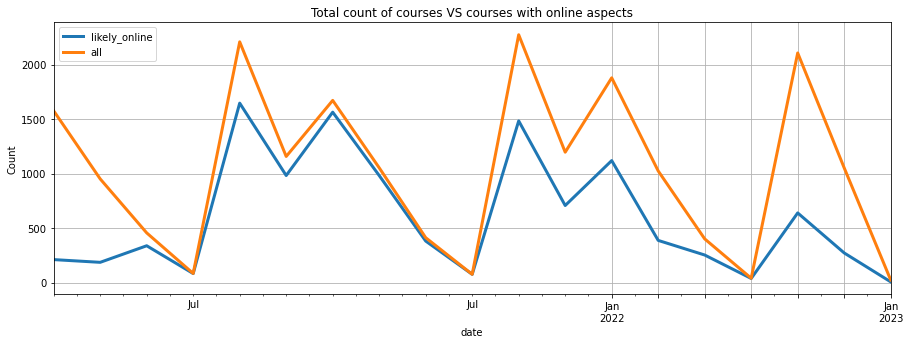

In [773]:
monthly_teaching_df = df.copy().loc[~df["open_uni"]]

monthly_teaching_df = monthly_teaching_df.loc[is_teaching].groupby(pd.Grouper(key="date", freq="2M")).sum()
monthly_teaching_df[['likely_online', 'all']].plot(
    figsize=(15, 5), grid=True, xticks=xticks, linewidth=3, ylabel="Count",
    title="Total count of courses VS courses with online aspects"
    )

### Graph the keyword counts

<AxesSubplot:title={'center':'Total number of courses with keywords in notices'}, xlabel='date', ylabel='Count'>

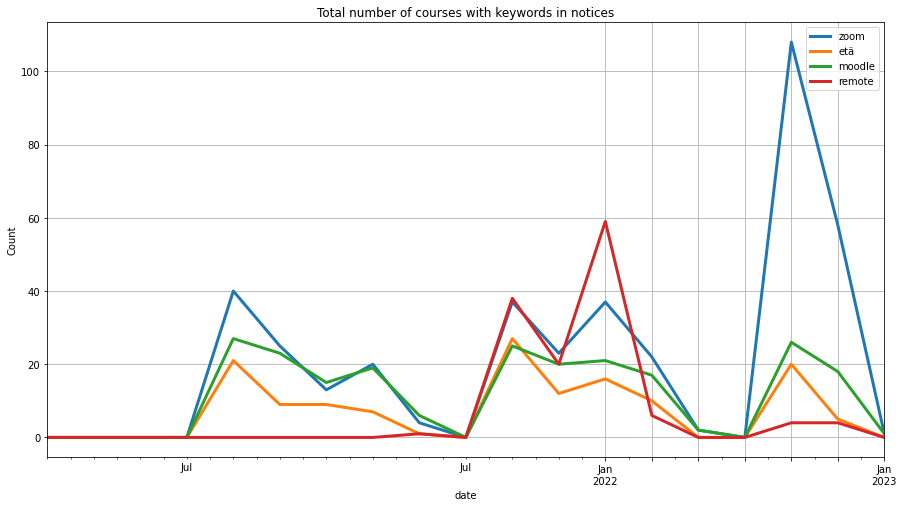

In [774]:
monthly_teaching_df[['zoom', 'etä', 'moodle', 'remote']].plot(
    figsize=(15, 8), grid=True, xticks=xticks, linewidth=3, ylabel="Count", 
    title="Total number of courses with keywords in notices"
    )

<AxesSubplot:title={'center':'Fraction of teaching courses that have keywords in their study event notices'}, xlabel='date'>

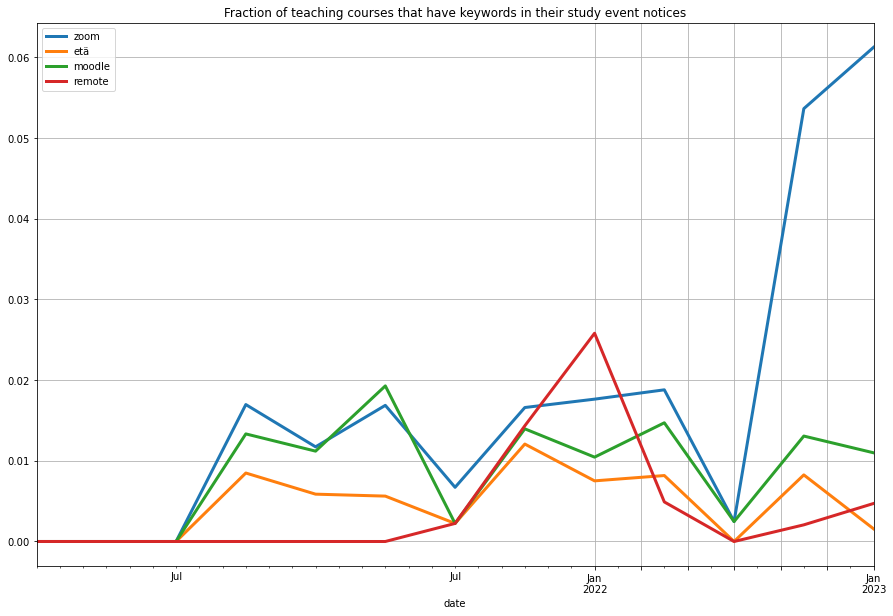

In [775]:
monthly_teaching_df = df.copy()
monthly_teaching_df = monthly_teaching_df.loc[is_teaching].groupby(pd.Grouper(key="date", freq="3M")).mean()
monthly_teaching_df[['zoom', 'etä', 'moodle', 'remote']].plot(
    figsize=(15, 10), grid=True, xticks=xticks, linewidth=3, 
    title="Fraction of teaching courses that have keywords in their study event notices",
    )

TypeError: matplotlib.axes._axes.Axes.bar() got multiple values for keyword argument 'label'

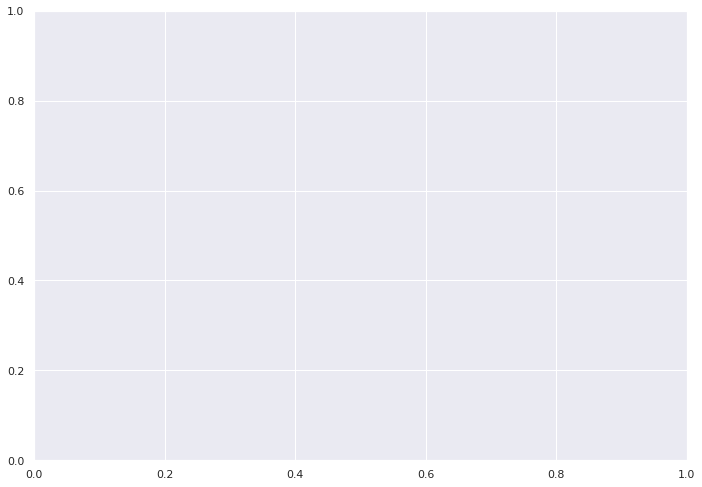

In [806]:

is_teaching = df['type'].str.startswith('teaching')
is_open = df['open_uni']

df0 = df.copy().loc[df['date'] > '2022-01-01']

def period(month):
    if month < 3:
        return 'P3'
    elif month < 6:
        return 'P4'
    elif month < 7:
        return 'K1'
    elif month < 8:
        return 'K2'
    elif month < 10:
        return 'P1'
    elif month <= 12:
        return 'P2'

df0["period"] = pd.DatetimeIndex(df0["date"]).month.map(period)

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(
    data=df0, 
    x="period", 
    y="likely_online", 
    hue="open_uni", 
    order=["P3", "P4", "K1", "K2", "P1", "P2"]
    )